# The Error-State Extended Kalman Filter

<table>
<tr>
    <td> <img src="i/ekf1.png" alt="The Error-State Extended Kalman Filter" width="600"/> </td>
    <td> <img src="i/ekf2.png" alt="The Error-State Extended Kalman Filter" width="600"/> </td>
</tr>

<tr>
    <td> <img src="i/ekf3.png" alt="The Error-State Extended Kalman Filter" width="600"/> </td>
    <td> <img src="i/ekf4.png" alt="The Error-State Extended Kalman Filter" width="600" /> </td>
</tr>

<tr>
    <td> <img src="i/ekf5.png" alt="The Error-State Extended Kalman Filter" width="600"/> </td>
    <td> <img src="i/ekf6.png" alt="The Error-State Extended Kalman Filter" width="600"/> </td>
</tr>

</table>


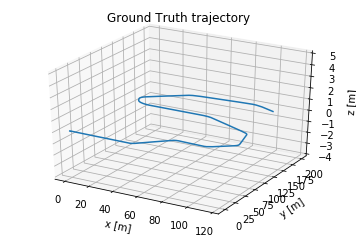

In [2]:
import pickle
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rotations import angle_normalize, rpy_jacobian_axis_angle, skew_symmetric, Quaternion
f = open('data/pt1_data.pkl', 'rb')
data = pickle.load(f)

################################################################################################
#   gt: Data object containing ground truth. with the following fields:
#     a: Acceleration of the vehicle, in the inertial frame
#     v: Velocity of the vehicle, in the inertial frame
#     p: Position of the vehicle, in the inertial frame
#     alpha: Rotational acceleration of the vehicle, in the inertial frame
#     w: Rotational velocity of the vehicle, in the inertial frame
#     r: Rotational position of the vehicle, in Euler (XYZ) angles in the inertial frame
#     _t: Timestamp in ms.
#   imu_f: StampedData object with the imu specific force data (given in vehicle frame).
#     data: The actual data
#     t: Timestamps in ms.
#   imu_w: StampedData object with the imu rotational velocity (given in the vehicle frame).
#     data: The actual data
#     t: Timestamps in ms.
#   gnss: StampedData object with the GNSS data.
#     data: The actual data
#     t: Timestamps in ms.
#   lidar: StampedData object with the LIDAR data (positions only).
#     data: The actual data
#     t: Timestamps in ms.
################################################################################################

gt = data['gt']         # Data object containing ground truth
imu_f = data['imu_f']   # imu_f.data, imu_f.t are IMU force data and timestamps (given in vehicle frame)
imu_w = data['imu_w']   # imu rotational velocity (given in the vehicle frame)
gnss = data['gnss']     # StampedData object with the GNSS data.
lidar = data['lidar']   # StampedData object with the LIDAR data (positions only)

gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth trajectory')
ax.set_zlim(-4, 5)
plt.show()

## Calibration rotation matrix

- LIDAR data is a set of positions estimated from a separate scan-matching system. 
- The LIDAR frame is not the same as the frame shared by the IMU and the GNSS. 
- We need to transform the LIDAR data to the IMU frame using our a known extrinsic calibration rotation matrix $C_{li}$ and translation vector $t^{i}_{li} $


In [3]:
C_li = np.array([
   [ 0.99376, -0.09722,  0.05466],
   [ 0.09971,  0.99401, -0.04475],
   [-0.04998,  0.04992,  0.9975 ]
])

# Translation vector from lidar frame to vehicle frame 
t_i_li = np.array([0.5, 0.1, 0.5])

# Transform from the LIDAR frame to the vehicle (IMU) frame.
lidar.data = (C_li @ lidar.data.T).T + t_i_li

## Initial Values 

In [4]:
################################################################################################
## Estimated sensor variances.
################################################################################################
var_imu_f = 0.10
var_imu_w = 0.25

var_gnss  = 0.01
R_gnss = var_gnss * np.identity(3)

var_lidar = 1.00
R_lidar = var_lidar * np.identity(3)

################################################################################################
# Set up some constants that won't change for any iteration
################################################################################################
g = np.array([0, 0, -9.81])  # gravity
l_jac = np.zeros([9, 6])
l_jac[3:, :] = np.eye(6)  # motion model noise jacobian
h_jac = np.zeros([3, 9])
h_jac[:, :3] = np.eye(3)  # measurement model jacobian


################################################################################################
# Initial Values
################################################################################################
p_est = np.zeros([imu_f.data.shape[0], 3])  # position estimates
v_est = np.zeros([imu_f.data.shape[0], 3])  # velocity estimates
q_est = np.zeros([imu_f.data.shape[0], 4])  # orientation estimates as quaternions
p_cov = np.zeros([imu_f.data.shape[0], 9, 9])  # covariance matrices at each timestep

# Set initial values.
p_est[0] = gt.p[0]
v_est[0] = gt.v[0]
q_est[0] = Quaternion(euler=gt.r[0]).to_numpy()
p_cov[0] = np.zeros(9)  # covariance of estimate
gnss_i  = 0
lidar_i = 0

# Motion and sensor models 

<table>
<tr>
    <td> <img src="i/vars.png" alt="state and input vectors" width="1220"/> </td>
</tr>
</table>

### Quaternions $ q_k $
- Quaternions $ [q_1 \quad q_2, \quad ..., \quad q_k  ] $ are 4D unit quaternions that will represent the orientations of our vehicle with respect to the navigation frame.
- I.e. $q_k$ keeps track of the orientation of our sensor frame $s$, with respect to our navigation frame $n$ at time $k$

<table>
<tr>
    <td> <img src="i/f.png" alt="motion model" width="600"/> </td>
    <td> <img src="i/f_linear.png" alt="motion model" width="600"/> </td>
</tr>

<tr>
    <td> <img src="i/h1.png" alt="sensor model - GPS" width="600"/> </td>
    <td> <img src="i/h2.png" alt="sensor model - LIDAR" width="600"/> </td>
</tr></table>


<table>
<tr>
    <td> <img src="i/q.png" alt="Represent rotations with quaternions" width="1220"/> </td>
</tr>
</table>

</table>

In [5]:
# Motion model: function f1
def f1(p, v, f, dt, C):
    "Predict state p[k] using IMU input, f[k-1], and prev estimates p[k-1], v[k-1]"
    f_ns = C @ f
    p_k_check = p + dt*v + 0.5*dt*dt * (f_ns + g)
    return p_k_check

# Model model: function f2
def f2(v, f, dt, C):
    "Predict state v[k] using IMU input, f[k-1], and prev estimate v[k-1]"
    f_ns = C @ f
    v_k_check = v + dt * (f_ns + g)
    return v_k_check

# Motion model: function f3 do orientation update
def f3(q, omega, dt):
    "Predict state q[k] using IMU input, omega[k-1], and prev estimate q[k-1]"
    delta_omega = dt*omega
    delta_omega_quaternion = Quaternion(euler=delta_omega)
    q_k = delta_omega_quaternion.quat_mult_right(q)
    return q_k

def jacobianF(f, dt, C):
    "Find jacobian matrix F"    
    F = np.identity(9)

    # Block (1, 2)
    b12 = dt*np.identity(3)
    F[0:3, 3:6] = b12

    # Block (2, 3)
    # C, C_sn, is the orientations q[k-1] of the IMU sensor with respect to the navigation frame
    # C represents rotation of local vector q[k-1] to the global frame where the state is
    # based on the estimated quaternion
    f_ns = C @ f # f_ns is all of the non-gravity forces transformed to the world frame 

    # Then taking the Jacobian with respect to the error state, 
    # the partial derivative of the velocity equation with respect to the rotational error state 
    # only needs to consider forces that are perpendicular to the current orientation
    # 
    # Thus the jacobian entry, block (2, 3), is the cross product of the force vector 
    # with the rotational error state
    # 
    # [ ]x  operator is the cross-product matrix 
    # https://en.wikipedia.org/wiki/Cross_product#Conversion_to_matrix_multiplication    
    b23 = -1 * skew_symmetric(f_ns) * dt 
    F[3:6, 6:] = b23
    
    return F

def Qk(dt):
    Q_km1 = np.zeros([6, 6])
    Q_km1[0:3, 0:3] = var_imu_f*np.identity(3)
    Q_km1[3:, 3:] = var_imu_w * np.identity(3)
    Q_km1 = (dt * dt) * Q_km1
    return Q_km1

### Main Filter Loop

<table>
<tr>
    <td> <img src="i/p0a.png" alt="sensor model - GPS" width="600"/> </td>
    <td> <img src="i/p0b.png" alt="sensor model - LIDAR" width="600"/> </td>
</tr>

<tr>
    <td> <img src="i/p1.png" alt="sensor model - GPS" width="600"/> </td>
    <td> <img src="i/p2.png" alt="sensor model - LIDAR" width="600"/> </td>
</tr>
<tr>
    <td> <img src="i/c1.png" alt="sensor model - GPS" width="600"/> </td>
    <td> <img src="i/c2.png" alt="sensor model - LIDAR" width="600"/> </td>
</tr>
<tr>
    <td> <img src="i/c3.png" alt="sensor model - GPS" width="600"/> </td>
    <td> <img src="i/c4.png" alt="sensor model - LIDAR" width="600"/> </td>
</tr>
</table>


In [6]:
def measurement_update(sensor_var, p_cov_check, y_k, p_check, v_check, q_check):
    P = p_cov_check    
    H = h_jac
    R = np.identity(3) 
    
    if sensor_var == "GNSS":
        R = R_gnss

    if sensor_var == "LIDAR":
        R = R_lidar

    # 3.1 Compute Kalman Gain
    K = np.dot(P, H.T).dot( inv( np.dot(H, P).dot(H.T)  + R ) )
    
    # 3.2 Compute error state
    residual = (y_k - p_check) 
    delta_x = K.dot(residual)

    delta_p = delta_x[0:3,]
    delta_v = delta_x[3:6,]
    delta_phi = delta_x[6:,]
    
    # 3.3 Correct predicted state
    p_hat = p_check + delta_p
    v_hat = v_check + delta_v
    delta_phi_quaternion =  Quaternion(euler=delta_phi)
    q_hat = Quaternion(*q_check).quat_mult_right(delta_phi_quaternion)

    # 3.4 Compute corrected covariance
    p_cov_hat = (np.identity(9) - np.dot(K, H)).dot(p_cov_check)
    return p_hat, v_hat, q_hat, p_cov_hat


In [7]:
def propagate_uncertainty(F, P, L, Q):
    P_check = np.dot(F, P).dot(F.T) +  np.dot(L, Q).dot(L.T)
    return P_check

for k in range(1, imu_f.data.shape[0]):  # start at 1 b/c we have initial prediction from gt
    delta_t = imu_f.t[k] - imu_f.t[k - 1]

    # 1. Update state with IMU inputs
    C = Quaternion(*q_est[k-1]).to_mat()
    p_check = f1(p_est[k-1], v_est[k-1], imu_f.data[k-1], delta_t, C)
    v_check = f2(v_est[k-1], imu_f.data[k-1], delta_t, C)
    q_check = f3(q_est[k-1], imu_w.data[k-1], delta_t)
    
    # 1.1 Linearize the motion model and compute Jacobians
    F = jacobianF(imu_f.data[k-1], delta_t, C)
    L = l_jac
    Q_km1 = Qk(delta_t)
    P = p_cov[k-1]

    # 2. Propagate uncertainty
    P_cov_check = propagate_uncertainty(F, P, L, Q_km1)

    # 3. Check availability of GNSS and LIDAR measurements
    if gnss_i < len(gnss.t) and gnss.t[gnss_i] <=  imu_f.t[k]: # GNSS measurements available 
        gnss_data = gnss.data[gnss_i]
        p_check, v_check, q_check, P_cov_check = measurement_update("GNSS", P_cov_check, gnss_data, p_check, v_check, q_check)
        gnss_i = gnss_i + 1

    if lidar_i < len(lidar.t) and  lidar.t[lidar_i] <=  imu_f.t[k]: # lidar measurements available 
        lidar_data = lidar.data[lidar_i]
        p_check, v_check, q_check, P_cov_check = measurement_update("LIDAR", P_cov_check, lidar_data, p_check, v_check, q_check)
        lidar_i = lidar_i + 1

    # Update states (save)
    p_est[k] = p_check
    v_est[k] = v_check
    q_est[k] = q_check
    p_cov[k] = P_cov_check 

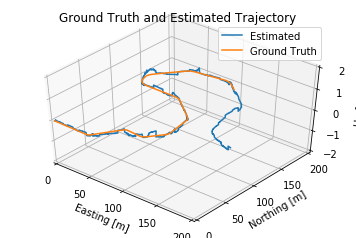

In [11]:
#### 6. Results and Analysis ###################################################################

################################################################################################
# Now that we have state estimates for all of our sensor data, let's plot the results. This plot
# will show the ground truth and the estimated trajectories on the same plot. Notice that the
# estimated trajectory continues past the ground truth. This is because we will be evaluating
# your estimated poses from the part of the trajectory where you don't have ground truth!
################################################################################################
est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection='3d')
ax.plot(p_est[:,0], p_est[:,1], p_est[:,2], label='Estimated')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2], label='Ground Truth')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_zlabel('Up [m]')
ax.set_title('Ground Truth and Estimated Trajectory')
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_zlim(-2, 2)
ax.set_xticks([0, 50, 100, 150, 200])
ax.set_yticks([0, 50, 100, 150, 200])
ax.set_zticks([-2, -1, 0, 1, 2])
ax.legend(loc=(0.62,0.77))
ax.view_init(elev=45, azim=-50)
plt.show()

# plot the error

Plot the error for each of the 6 DOF, with estimates for uncertainty included. 

- The error estimates are in blue, and the uncertainty bounds are red and dashed.
-  The uncertainty bounds are +/- 3 standard deviations based on our uncertainty (covariance).

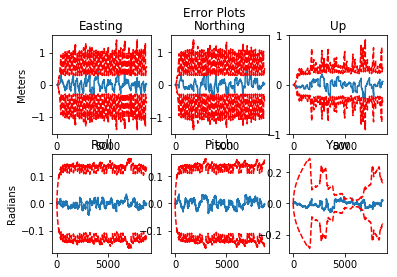

In [12]:
error_fig, ax = plt.subplots(2, 3)
error_fig.suptitle('Error Plots')
num_gt = gt.p.shape[0]
p_est_euler = []
p_cov_euler_std = []

# Convert estimated quaternions to euler angles
for i in range(len(q_est)):
    qc = Quaternion(*q_est[i, :])
    p_est_euler.append(qc.to_euler())

    # First-order approximation of RPY covariance
    J = rpy_jacobian_axis_angle(qc.to_axis_angle())
    p_cov_euler_std.append(np.sqrt(np.diagonal(J @ p_cov[i, 6:, 6:] @ J.T)))

p_est_euler = np.array(p_est_euler)
p_cov_euler_std = np.array(p_cov_euler_std)

# Get uncertainty estimates from P matrix
p_cov_std = np.sqrt(np.diagonal(p_cov[:, :6, :6], axis1=1, axis2=2))

titles = ['Easting', 'Northing', 'Up', 'Roll', 'Pitch', 'Yaw']
for i in range(3):
    ax[0, i].plot(range(num_gt), gt.p[:, i] - p_est[:num_gt, i])
    ax[0, i].plot(range(num_gt),  3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].plot(range(num_gt), -3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].set_title(titles[i])
ax[0,0].set_ylabel('Meters')

for i in range(3):
    ax[1, i].plot(range(num_gt), \
        angle_normalize(gt.r[:, i] - p_est_euler[:num_gt, i]))
    ax[1, i].plot(range(num_gt),  3 * p_cov_euler_std[:num_gt, i], 'r--')
    ax[1, i].plot(range(num_gt), -3 * p_cov_euler_std[:num_gt, i], 'r--')
    ax[1, i].set_title(titles[i+3])
ax[1,0].set_ylabel('Radians')
plt.show()


In [13]:
p1_indices = [9000, 9400, 9800, 10200, 10600]
p1_str = ''
for val in p1_indices:
    for i in range(3):
        p1_str += '%.3f ' % (p_est[val, i])
with open('pt1_submission.txt', 'w') as file:
    file.write(p1_str)
